# Adversarial validation

Adversarial validation is a technique introduced by Uber engineers in 2020 in their paper ["Adversarial Validation Approach to Concept Drift Problem in
User Targeting Automation Systems at Uber"](https://arxiv.org/pdf/2004.03045).

It aims at solving the problem of concept drift by exploring similarities before training data and test data.

In this notebook, I explore this approach on a Dataset from the Data Science Challenge of ITA EEF 2024 available at [Kaggle](https://www.kaggle.com/competitions/data-science-challenge-at-eef-2024/overview).



## Data

The data consists of ...

In [1]:
import pandas as pd

df = pd.read_csv('processed_public.csv')
df.info()

C:\Users\jgori\AppData\Local\Temp\ipykernel_21256\2143058644.py:3: DtypeWarning: Columns (21,49,76,80,93,104,108,121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('processed_public.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302399 entries, 0 to 302398
Columns: 122 entries, flightid to remarks_destino_metaf
dtypes: float64(79), int64(2), object(41)
memory usage: 281.5+ MB


In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from io import StringIO
from metpy.io import parse_metar_file

# class DropDuplicates(BaseEstimator, TransformerMixin):
#     def __init__(self, exclude):
#         self.exclude = exclude
    
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X, y=None):
#         X = X.drop_duplicates(X.columns.difference(self.exclude))
#         return X

# class ParseMetarTransformer(BaseEstimator, TransformerMixin):    
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X, y=None):
        
#         def _parse(column):
#             X.loc[:, column] = X[column].str.replace('METAF', 'METAR')
#             X.loc[:, column] = X[column].fillna(value=' ')
#             data = X[column].values
#             index = X[column].index
#             res = parse_metar_file(StringIO('\n'.join(val for val in data)))
#             res.index = index
#             return res
        
#         if 'latitude' in X.columns:  # already parsed
#             return X
#         X = X.join(_parse('metar'), rsuffix='_metar')
#         X.loc[:, 'metaf'] = X['metaf'].str.replace('METAF', 'METAR')
#         X = X.join(_parse('metaf'), rsuffix='_metaf')
#         return X

class TimeInformation(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        time_data = pd.to_datetime(X['hora_ref'])
        b = [0, 4, 8, 12, 16, 20, 24]
        l = ['late night', 'early morning', 'morning', 'noon', 'evening', 'night']
        X['period_day'] = pd.cut(time_data.dt.hour, bins=b, labels=l, include_lowest=True)
        X['day_of_week'] =  pd.Categorical(time_data.dt.day_of_week)
        # X['season'] = 'low'
        # X.loc[(10 <= time_data.dt.month)|(time_data.dt.month <= 3), 'season'] = 'high'
        return X

class CabeceiraTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['prev_troca_cabeceira'] = X['prev_troca_cabeceira'].astype(bool)
        X['troca_cabeceira_hora_anterior'] = X['troca_cabeceira_hora_anterior'].astype(bool)
        return X


class CombineMetarTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features=None, num_features=None):
        self.cat_features = cat_features
        self.num_features = num_features
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for feature in self.cat_features:
            # X[f'{feature}_combined'] = X[f'{feature}_metar'].fillna(X[f'{feature}_metaf'])
            X[feature] = X[f'{feature}_metar'].fillna(X[f'{feature}_metaf'])
            # X.drop(columns=[feature, f'{feature}_metaf'], inplace=True)
        for feature in self.num_features:
            # X[f'{feature}_mean'] = X[[f'{feature}_metar', f'{feature}_metaf']].mean(axis=1)
            X[feature] = X[[f'{feature}_metar', f'{feature}_metaf']].mean(axis=1)
            # X.drop(columns=[feature, f'{feature}_metaf'], inplace=True)
        return X

# # TODO implement origem destino in this one
# class WindDirectionTransformer(TransformerMixin, BaseEstimator):
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X, y=None):
#         X['wind_direction_vrb_origem'] = False
#         wind_direction_vrb = (X['wind_direction_origem_mean'].isna()) & (X['metar'].str.contains('VRB'))
#         X.loc[wind_direction_vrb, 'wind_direction_vrb'] = True
#         return X


class WeatherTransformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['current_wx_origem'] = X['current_wx1_origem'].fillna('') + X['current_wx2_origem'].fillna('') + X['current_wx3_origem'].fillna('')
        X['current_wx_destino'] = X['current_wx1_destino'].fillna('') + X['current_wx2_destino'].fillna('') + X['current_wx3_destino'].fillna('')

        intensity_cat = ['VC', '-', '', '+']
        descriptor_cat = ['MI', 'PR', 'BC', 'DR', 'BL', 'SH', 'TS', 'FZ']
        descriptor_cat = [i+d for i in intensity_cat for d in descriptor_cat]
        precipitation_cat = ['DZ', 'RA', 'SN', 'SG', 'IC', 'PL', 'GR', 'GS', 'UP']
        precipitation_cat = [i+d for i in intensity_cat for d in precipitation_cat]
        obscuration_cat = ['BR', 'FG', 'FU', 'VA', 'DU', 'SA', 'HZ', 'PY']
        obscuration_cat = [i+d for i in intensity_cat for d in obscuration_cat]
        other_cat = ['PO', 'SQ', 'FC', 'SS', 'DS']
        other_cat = [i+d for i in intensity_cat for d in other_cat]
        weather_categories = descriptor_cat + precipitation_cat + obscuration_cat + other_cat

        X['current_wx_origem'] = pd.Categorical(X['current_wx_origem'], categories=weather_categories)
        X['current_wx_destino'] = pd.Categorical(X['current_wx_destino'], categories=weather_categories)
        return X

In [3]:
from sklearn.pipeline import Pipeline
pd.options.mode.chained_assignment = None

metar_num_features = ['wind_direction', 
                      'wind_speed', 
                      'wind_gust', 
                      'visibility', 
                      'low_cloud_level', 
                      'medium_cloud_level', 
                      'high_cloud_level', 
                      'highest_cloud_level', 
                      'cloud_coverage', 
                      'air_temperature', 
                      'dew_point_temperature',
                      'altimeter',
                     ]
metar_num_features = [f+'_origem' for f in metar_num_features] + [f+'_destino' for f in metar_num_features]

metar_cat_features = ['low_cloud_type', 
                      'medium_cloud_type', 
                      'high_cloud_type', 
                      'highest_cloud_type', 
                      'current_wx1',
                      'current_wx2',
                      'current_wx3'
                     ]
metar_cat_features = [f+'_origem' for f in metar_cat_features] + [f+'_destino' for f in metar_cat_features]

create_features_pipeline = Pipeline([
    # ('duplicates', DropDuplicates(['flightid'])),
    ('cabeceira', CabeceiraTransformer()),
    # ('parse_metar', ParseMetarTransformer()),
    ('time', TimeInformation()),
    ('combine_metar', CombineMetarTransformer(
        cat_features=metar_cat_features,
        num_features=metar_num_features,
    )),
    # ('wind_vrb', WindDirectionTransformer()),
    ('weather', WeatherTransformer()),
])

df = create_features_pipeline.fit_transform(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302399 entries, 0 to 302398
Columns: 164 entries, flightid to current_wx_destino
dtypes: bool(2), category(4), float64(103), object(55)
memory usage: 366.3+ MB


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer

num_median_features = ['wind_direction', 'wind_speed', 'visibility', 'cloud_coverage', 'air_temperature', 'dew_point_temperature', 'altimeter']
num_median_features = [f+'_origem' for f in num_median_features] + [f+'_destino' for f in num_median_features]
num_median_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

num_zero_features = ['wind_gust']
num_zero_features = [f+'_origem' for f in num_zero_features] + [f+'_destino' for f in num_zero_features]
num_zero_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler()),
])

# bin_features = ['prev_troca_cabeceira', 'troca_cabeceira_hora_anterior', 'wind_direction_vrb']
bin_features = ['prev_troca_cabeceira', 'troca_cabeceira_hora_anterior']
# bin_features = [f+'_origem' for f in bin_features] + [f+'_destino' for f in bin_features]
bin_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

cat_features = ['origem', 'destino', 'period_day', 'day_of_week']
# cat_features = ['period_day', 'day_of_week']
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
])

weather_features = ['current_wx']
weather_features = [f+'_origem' for f in weather_features] + [f+'_destino' for f in weather_features]
weather_pipeline = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

clouds_num_features = ['low_cloud_level', 'medium_cloud_level', 'high_cloud_level', 'highest_cloud_level']
clouds_num_features = [f+'_origem' for f in clouds_num_features] + [f+'_destino' for f in clouds_num_features]
clouds_num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=20000)),
    ('scaler', StandardScaler()),
])

clouds_cat_features = ['low_cloud_type', 'medium_cloud_type', 'high_cloud_type', 'highest_cloud_type']
clouds_cat_features = [f+'_origem' for f in clouds_cat_features] + [f+'_destino' for f in clouds_cat_features]
clouds_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='SKC')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

time_features = ['hora_ref']
time_pipeline = Pipeline([
    
])


data_pipeline = ColumnTransformer([
    ('num_median', num_median_pipeline, num_median_features),
    ('num_zero', num_zero_pipeline, num_zero_features),
    ('binary', bin_pipeline, bin_features),
    ('cat', cat_pipeline, cat_features),
    ('weather', weather_pipeline, weather_features),
    ('clouds_num', clouds_num_pipeline, clouds_num_features),
    ('clouds_cat', clouds_cat_pipeline, clouds_cat_features),
])

## Raw data exploration

In [5]:
train_data = df.loc[df['espera'].notna()]
test_data = df.loc[df['espera'].isna()]

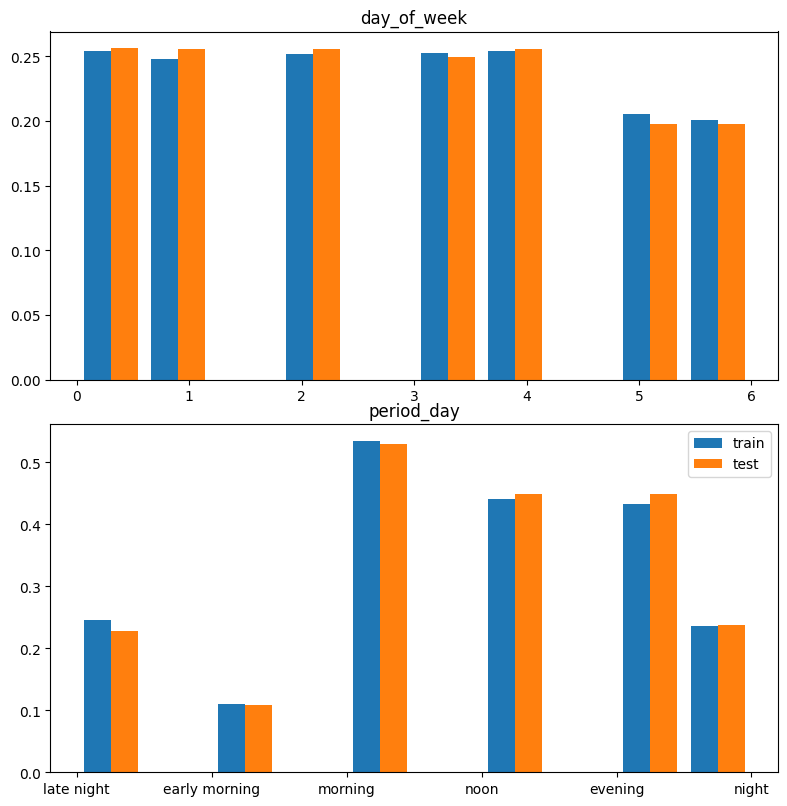

In [29]:
import matplotlib.pyplot as plt

features = ['day_of_week', 'period_day']

fig, axs = plt.subplots(len(features), figsize=(8,8))
fig.tight_layout()
for i, feature in enumerate(features):
    axs[i].hist([train_data[feature], test_data[feature]], label=['train', 'test'], density=True)
    axs[i].set_title(feature)
plt.legend()
plt.show()

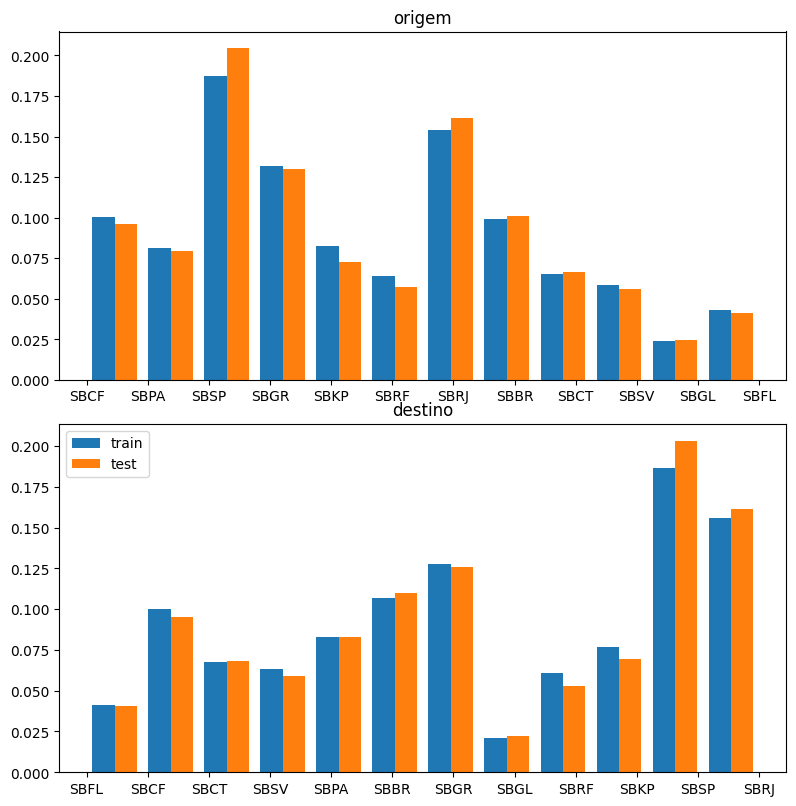

In [30]:
import matplotlib.pyplot as plt

features = ['origem', 'destino']

fig, axs = plt.subplots(len(features), figsize=(8,8))
fig.tight_layout()
for i, feature in enumerate(features):
    axs[i].hist([train_data[feature], test_data[feature]], label=['train', 'test'], bins=12, density=True)
    axs[i].set_title(feature)
plt.legend()
plt.show()

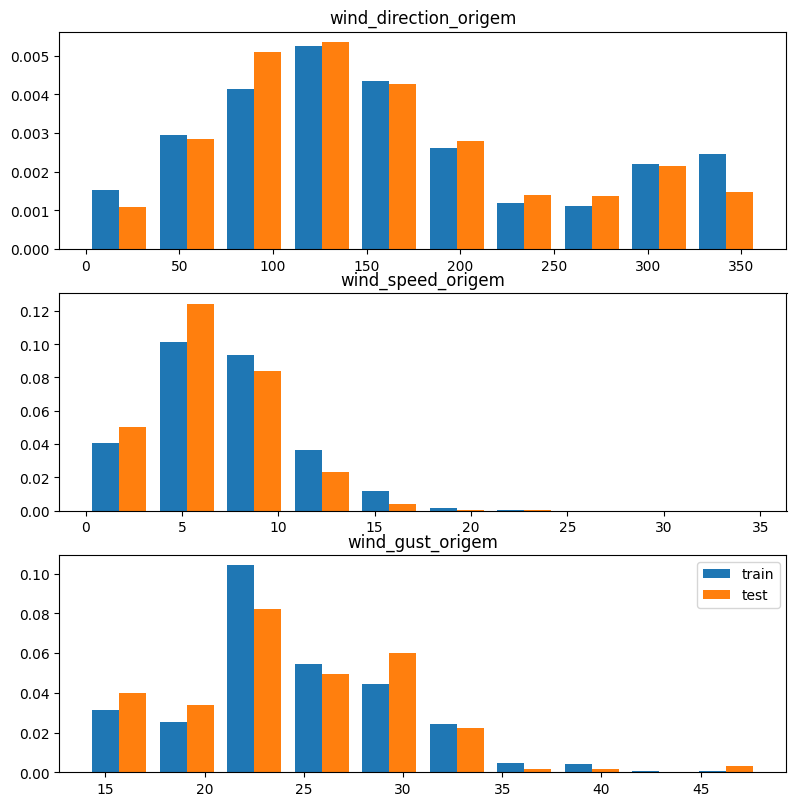

In [34]:
import matplotlib.pyplot as plt

features = ['wind_direction_origem', 'wind_speed_origem', 'wind_gust_origem']

fig, axs = plt.subplots(len(features), figsize=(8,8))
fig.tight_layout()
for i, feature in enumerate(features):
    axs[i].hist([train_data[feature], test_data[feature]], label=['train', 'test'], density=True)
    axs[i].set_title(feature)
plt.legend()
plt.show()

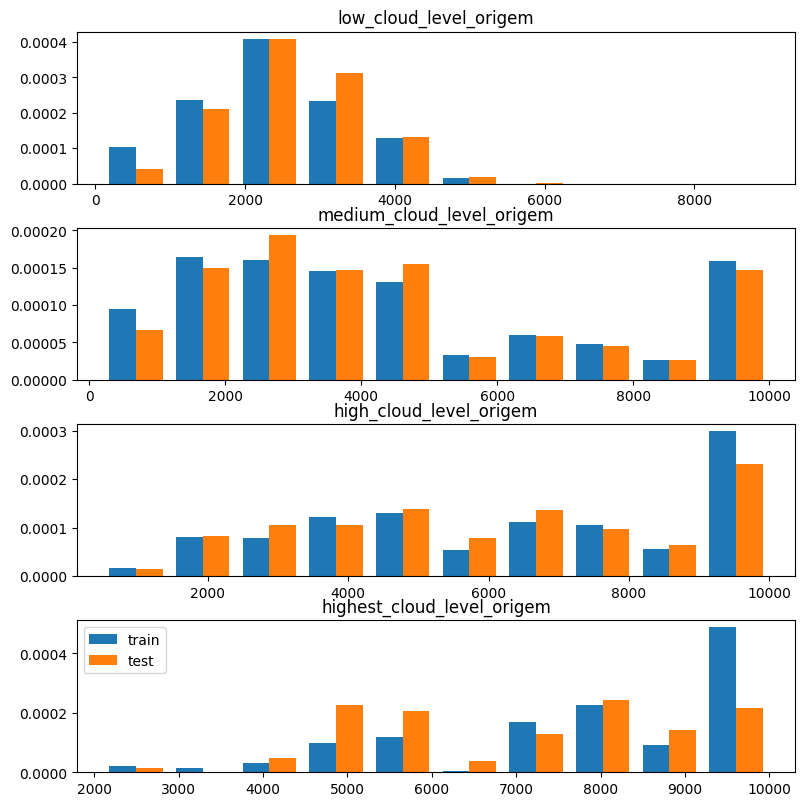

In [42]:
import matplotlib.pyplot as plt

features = ['low_cloud_level_origem', 'medium_cloud_level_origem', 'high_cloud_level_origem', 'highest_cloud_level_origem']

fig, axs = plt.subplots(len(features), figsize=(8,8))
fig.tight_layout()
for i, feature in enumerate(features):
    axs[i].hist([train_data[feature], test_data[feature]], label=['train', 'test'], density=True)
    axs[i].set_title(feature)
plt.legend()
plt.show()

## Train model

### Test with only training data

Is the model capable of telling training data apart, at random?

In [6]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2)

In [7]:
train_data['is_test'] = 0
test_data['is_test'] = 1
df = pd.concat([train_data, test_data])
df['is_test'].value_counts()

is_test
0    241919
1     60480
Name: count, dtype: int64

In [8]:
X = df.drop(columns=['espera', 'is_test'])
y = df[['is_test']]

print(X.info())
print(y.info())

<class 'pandas.core.frame.DataFrame'>
Index: 302399 entries, 106958 to 130
Columns: 163 entries, flightid to current_wx_destino
dtypes: bool(2), category(4), float64(102), object(55)
memory usage: 366.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 302399 entries, 106958 to 130
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   is_test  302399 non-null  int64
dtypes: int64(1)
memory usage: 4.6 MB
None


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

clf = Pipeline([
    ('features', create_features_pipeline),
    ('data', data_pipeline),
    ('model', XGBClassifier())
])

cv = KFold(
    n_splits=5,
    shuffle=True,
    random_state=0,
)

scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print(scores)

[0.4987586  0.49948527 0.50024296 0.49368085 0.49900997]


In [154]:
clf.fit(X, y)
y_pred = clf.predict_proba(X)[:, 1]

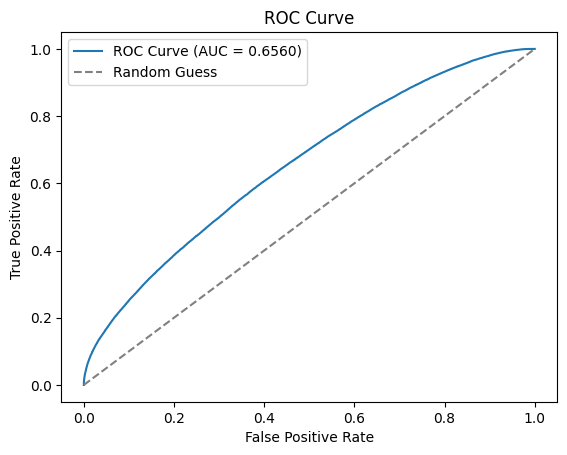

In [156]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

auc = roc_auc_score(y, y_pred)
fpr, tpr, _ = roc_curve(y, y_pred)
plt.plot(fpr, tpr, label = 'ROC Curve (AUC = %0.4f)' % auc)

plt.plot([0,1], [0,1], linestyle = '--', color = 'gray', label = 'Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [157]:
feature_importance = pd.Series(clf.named_steps['model'].feature_importances_, index=clf.named_steps['data'].get_feature_names_out()).sort_values(ascending=False)
feature_importance.head(50)

cat__destino_SBSV                             0.013473
weather__current_wx_destino_-DZ               0.013097
weather__current_wx_destino_VCTS              0.011973
cat__period_day_early morning                 0.011654
cat__period_day_late night                    0.011473
cat__origem_SBGL                              0.010912
cat__destino_SBCT                             0.010869
cat__day_of_week_4                            0.010588
weather__current_wx_origem_RA                 0.010583
cat__destino_SBFL                             0.010524
clouds_cat__low_cloud_type_destino_OVC        0.010498
clouds_cat__low_cloud_type_destino_BKN        0.010415
clouds_cat__highest_cloud_type_destino_OVC    0.010392
clouds_cat__medium_cloud_type_origem_BKN      0.010321
clouds_cat__low_cloud_type_origem_OVC         0.010245
cat__destino_SBGL                             0.010222
weather__current_wx_destino_-RA               0.010215
clouds_cat__low_cloud_type_origem_SKC         0.010062
cat__day_o

### Testing on actual test data

In [12]:
df['is_test'] = df['espera'].isna().astype(int)
df['is_test'].value_counts()

is_test
0    211679
1     90720
Name: count, dtype: int64

In [13]:
X = df.drop(columns=['espera', 'is_test'])
y = df[['is_test']]

print(X.info())
print(y.info())

<class 'pandas.core.frame.DataFrame'>
Index: 302399 entries, 106958 to 130
Columns: 163 entries, flightid to current_wx_destino
dtypes: bool(2), category(4), float64(102), object(55)
memory usage: 366.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 302399 entries, 106958 to 130
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   is_test  302399 non-null  int32
dtypes: int32(1)
memory usage: 3.5 MB
None


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

clf = Pipeline([
    ('features', create_features_pipeline),
    ('data', data_pipeline),
    ('model', XGBClassifier())
])

scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print(scores)

In [15]:
clf.fit(X, y)
y_pred = clf.predict_proba(X)[:, 1]

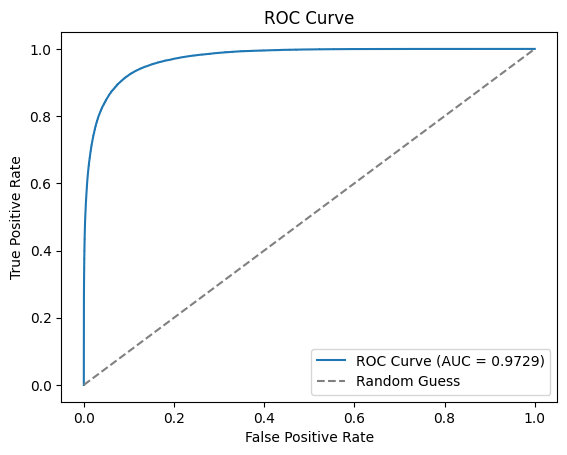

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

auc = roc_auc_score(y, y_pred)
fpr, tpr, _ = roc_curve(y, y_pred)
plt.plot(fpr, tpr, label = 'ROC Curve (AUC = %0.4f)' % auc)

plt.plot([0,1], [0,1], linestyle = '--', color = 'gray', label = 'Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [17]:
feature_importance = pd.Series(clf.named_steps['model'].feature_importances_, index=clf.named_steps['data'].get_feature_names_out()).sort_values(ascending=False)
feature_importance.head(50)

cat__origem_SBBR                             0.023910
clouds_cat__low_cloud_type_destino_SCT       0.022958
cat__destino_SBBR                            0.021919
cat__destino_SBRJ                            0.020091
cat__origem_SBRF                             0.019897
cat__origem_SBSP                             0.019491
cat__origem_SBRJ                             0.019017
clouds_cat__low_cloud_type_destino_VV        0.018938
cat__destino_SBSV                            0.018475
cat__origem_SBSV                             0.018312
cat__origem_SBCF                             0.017429
num_median__altimeter_origem                 0.017122
clouds_num__low_cloud_level_destino          0.016753
num_median__dew_point_temperature_origem     0.016578
clouds_num__low_cloud_level_origem           0.015952
clouds_cat__medium_cloud_type_origem_OVC     0.015692
num_median__cloud_coverage_destino           0.015257
cat__destino_SBCF                            0.015160
binary__prev_troca_cabeceira

## Distribution of features in training vs test data

In [37]:
test_data = df.loc[df['is_test'] == True, :]
train_data = df.loc[df['is_test'] == False, :]

In [38]:
proba = pd.Series(clf.predict_proba(X)[:, 1])
proba_test = proba[test_data.index]
proba_train = proba[train_data.index]

In [22]:
nrows = len(proba_train)
val_size = 0.2
new_val = proba_train.sort_values(ascending=False)[:int(nrows*val_size)]
new_train = proba_train.sort_values(ascending=False)[int(nrows*val_size):]
new_val.info()
new_train.info()

<class 'pandas.core.series.Series'>
Index: 42335 entries, 180604 to 76608
Series name: None
Non-Null Count  Dtype  
--------------  -----  
42335 non-null  float32
dtypes: float32(1)
memory usage: 496.1 KB
<class 'pandas.core.series.Series'>
Index: 169344 entries, 21625 to 82774
Series name: None
Non-Null Count   Dtype  
--------------   -----  
169344 non-null  float32
dtypes: float32(1)
memory usage: 1.9 MB


In [51]:
new_train = proba_train[proba_train < 0.7]
new_val = proba_train[proba_train >= 0.7]

In [ ]:
adversarial_validation_data = X.sort_values(by='proba',ascending=False)[:int(nrows*.2)]
adversarial_training_data = X_new.sort_values(by='proba',ascending=False)[int(nrows*.2):]

Text(0.5, 1.0, 'Distribuição dos pesos')

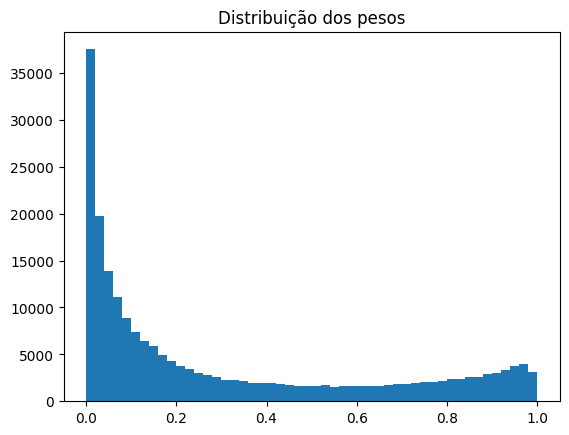

In [46]:
fig, ax = plt.subplots()
ax.hist(proba_train, bins=50)
ax.set_title('Distribuição dos pesos')

Text(0.5, 1.0, 'Dataset de treino')

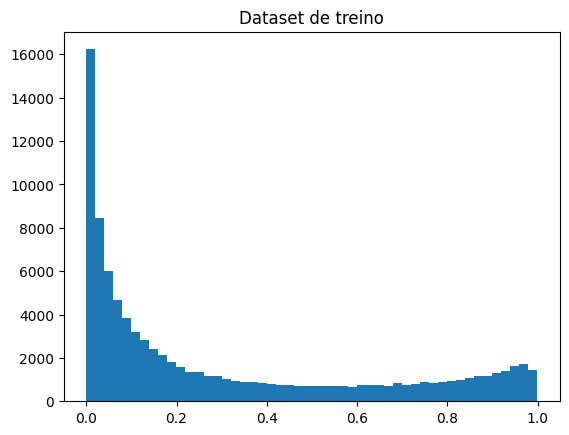

In [43]:
fig, ax = plt.subplots()
ax.hist(proba_test, bins=50)
ax.set_title('Dataset de treino')

In [45]:
th = 0.7
tmp = train_data.loc[proba_train[proba_train > th].index]['espera'].value_counts()
print(tmp)
print(tmp[1]/tmp[0])

espera
0.0    1627
1.0      28
Name: count, dtype: int64
0.017209588199139522


In [26]:
resample = train_data.loc[proba_train[proba_train > th].index]
resample.describe()

,espera,latitude_origem_metar,longitude_origem_metar,elevation_origem_metar,wind_direction_origem_metar,wind_speed_origem_metar,wind_gust_origem_metar,visibility_origem_metar,low_cloud_level_origem_metar,medium_cloud_level_origem_metar,...,visibility_destino,low_cloud_level_destino,medium_cloud_level_destino,high_cloud_level_destino,highest_cloud_level_destino,cloud_coverage_destino,air_temperature_destino,dew_point_temperature_destino,altimeter_destino,is_test
count,1655.000000,1550.000000,1550.000000,1550.000000,1417.000000,1550.000000,1.0,1550.000000,1128.000000,360.000000,...,1643.000000,1370.000000,367.000000,110.000000,4.000000,1643.000000,1636.000000,1636.000000,1636.000000,1655.0
mean,0.016918,-21.706161,-45.376226,506.847742,151.870148,5.668387,20.0,9501.914839,2304.166667,4516.666667,...,8982.404747,2588.722628,4879.019074,6609.090909,9325.000000,3.389531,24.000306,18.231968,30.027661,0.0
std,0.129005,5.280005,3.954465,404.455138,95.509133,2.784902,NaN,1427.515561,1136.843814,2865.771491,...,1966.997916,888.311102,2868.027752,2394.241772,830.160627,2.340750,4.168305,3.660577,0.085401,0.0
min,0.000000,-30.000000,-51.170000,3.000000,0.000000,0.000000,20.0,400.000000,100.000000,900.000000,...,250.000000,400.000000,800.000000,2000.000000,8300.000000,0.000000,11.000000,5.500000,29.589043,0.0
25%,0.000000,-23.620000,-47.920000,6.000000,80.000000,4.000000,20.0,9999.000000,1500.000000,2300.000000,...,8999.500000,2000.000000,2500.000000,5000.000000,8825.000000,2.000000,21.000000,16.000000,29.972933,0.0
50%,0.000000,-23.420000,-46.630000,750.000000,130.000000,5.000000,20.0,9999.000000,2100.000000,3600.000000,...,9999.000000,2500.000000,4000.000000,7000.000000,9500.000000,3.000000,24.500000,18.000000,30.031993,0.0
75%,0.000000,-19.630000,-43.250000,803.000000,210.000000,7.000000,20.0,10000.000000,3000.000000,6525.000000,...,9999.500000,3300.000000,6600.000000,8000.000000,10000.000000,5.000000,27.500000,22.000000,30.091053,0.0
max,1.000000,-8.130000,-34.920000,1061.000000,360.000000,17.000000,20.0,10000.000000,5000.000000,10000.000000,...,10000.000000,5000.000000,10000.000000,10000.000000,10000.000000,8.000000,33.000000,25.000000,30.238703,0.0


In [27]:
sample_weight = pd.Series(clf.predict_proba(X)[:,1]/clf.predict_proba(X)[:,0])
sample_weight.head(200)

0      0.069748
1      0.139482
2      0.291052
3      0.032212
4      0.132527
         ...   
195    0.087732
196    0.240423
197    0.287400
198    0.556398
199    0.130446
Length: 200, dtype: float32

In [28]:
sample_weight.to_csv('sample_weight_4.csv')

In [38]:
th = 0.7

re_train_data = train_data.loc[proba_train[proba_train > th].index]
re_train_data.shape

(1655, 165)

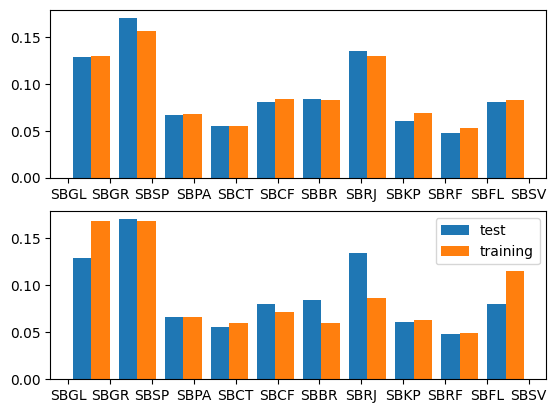

In [39]:
import matplotlib.pyplot as plt

feature = 'origem'

fig, axs = plt.subplots(2,1)
axs[0].hist([test_data[feature], train_data[feature]], 
        label=['test', 'training'],
        density=True)
axs[1].hist([test_data[feature], re_train_data[feature]], 
        label=['test', 'training'],
        density=True)
plt.legend()

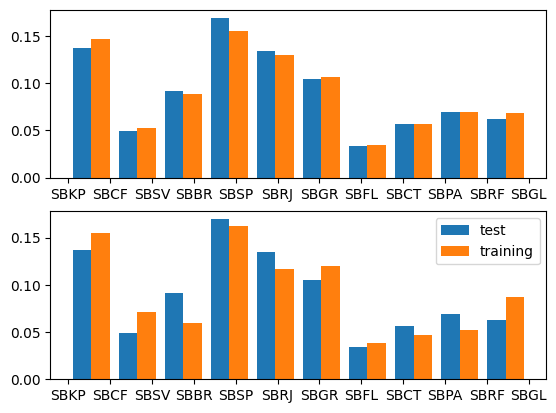

In [40]:
import matplotlib.pyplot as plt

feature = 'destino'

fig, axs = plt.subplots(2,1)
axs[0].hist([test_data[feature], train_data[feature]], 
        label=['test', 'training'],
        density=True)
axs[1].hist([test_data[feature], re_train_data[feature]], 
        label=['test', 'training'],
        density=True)
plt.legend()

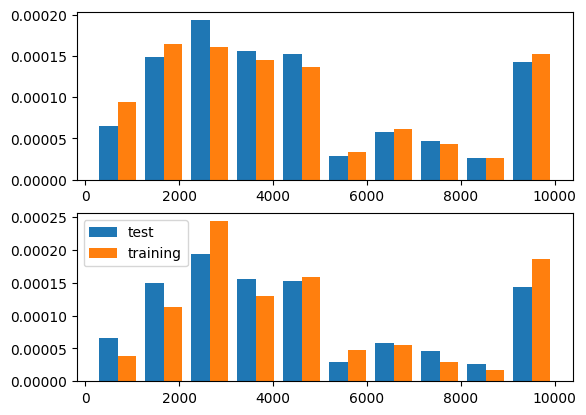

In [78]:
import matplotlib.pyplot as plt

feature = 'medium_cloud_level_destino'

fig, axs = plt.subplots(2,1)
axs[0].hist([test_data[feature], train_data[feature]], 
        label=['test', 'training'],
        density=True)
axs[1].hist([test_data[feature], re_train_data[feature]], 
        label=['test', 'training'],
        density=True)
plt.legend()

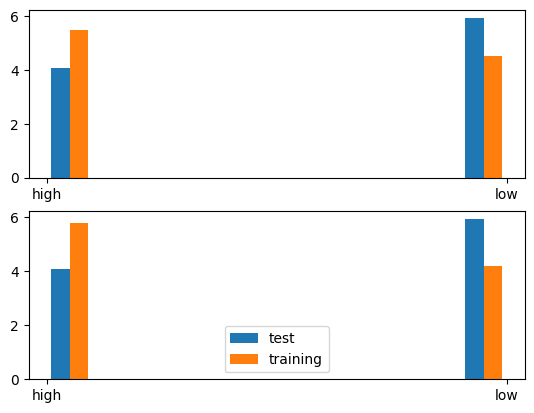

In [38]:
feature = 'season'

fig, axs = plt.subplots(2,1)
axs[0].hist([test_data[feature], train_data[feature]], 
        label=['test', 'training'],
        density=True)
axs[1].hist([test_data[feature], re_train_data[feature]], 
        label=['test', 'training'],
        density=True)
plt.legend()

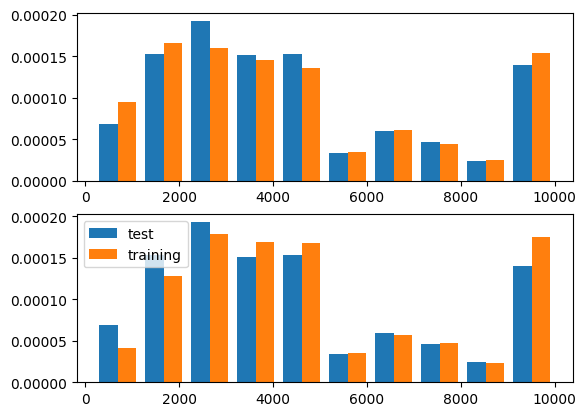

In [39]:
feature = 'medium_cloud_level_mean'

fig, axs = plt.subplots(2,1)
axs[0].hist([test_data[feature], train_data[feature]], 
        label=['test', 'training'],
        density=True)
axs[1].hist([test_data[feature], re_train_data[feature]], 
        label=['test', 'training'],
        density=True)
plt.legend()

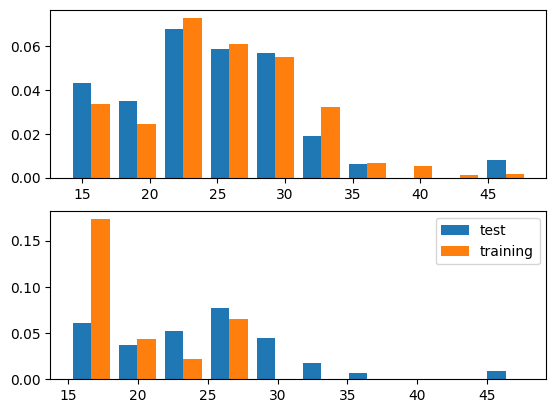

In [80]:
from matplotlib import pyplot as plt

feature = 'wind_gust_destino'

fig, axs = plt.subplots(2,1)
axs[0].hist([test_data[feature], train_data[feature]], 
        label=['test', 'training'],
        density=True)
axs[1].hist([test_data[feature], re_train_data[feature]], 
        label=['test', 'training'],
        density=True)
plt.legend()

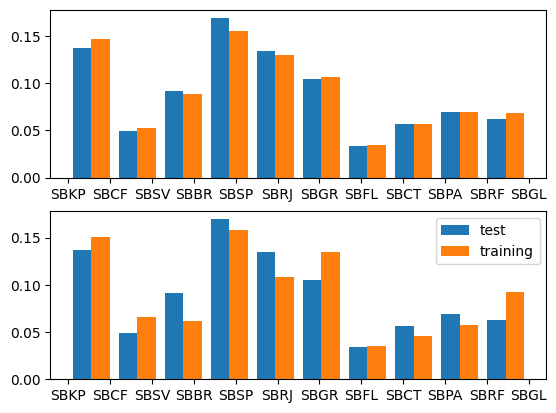

In [82]:
from matplotlib import pyplot as plt

feature = 'destino'

fig, axs = plt.subplots(2,1)
axs[0].hist([test_data[feature], train_data[feature]], 
        label=['test', 'training'],
        density=True)
axs[1].hist([test_data[feature], re_train_data[feature]], 
        label=['test', 'training'],
        density=True)
plt.legend()

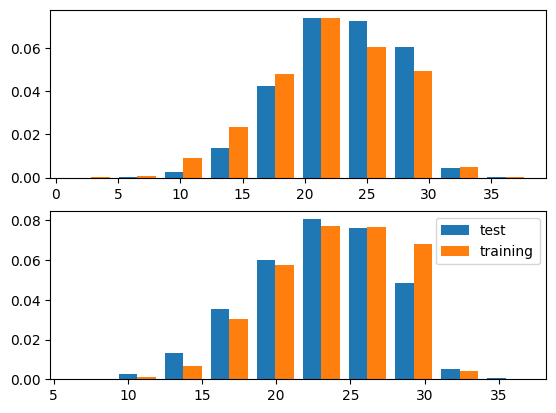

In [84]:
from matplotlib import pyplot as plt

feature = 'air_temperature_destino'

fig, axs = plt.subplots(2,1)
axs[0].hist([test_data[feature], train_data[feature]], 
        label=['test', 'training'],
        density=True)
axs[1].hist([test_data[feature], re_train_data[feature]], 
        label=['test', 'training'],
        density=True)
plt.legend()

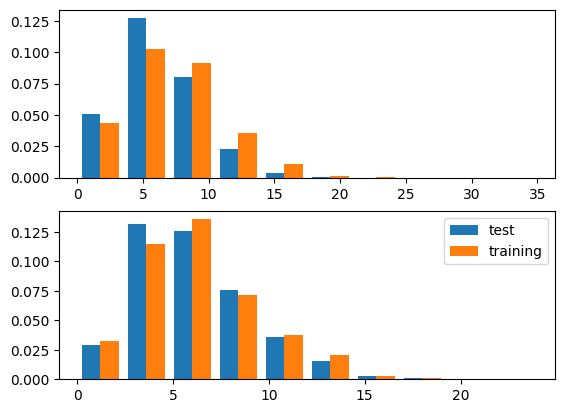

In [49]:
from matplotlib import pyplot as plt

feature = 'wind_speed_mean'

fig, axs = plt.subplots(2,1)
axs[0].hist([test_data[feature], train_data[feature]], 
        label=['test', 'training'],
        density=True)
axs[1].hist([test_data[feature], re_train_data[feature]], 
        label=['test', 'training'],
        density=True)
plt.legend()

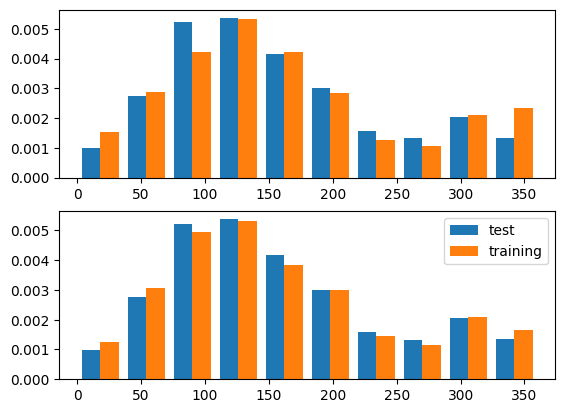

In [50]:
feature = 'wind_direction_mean'

fig, axs = plt.subplots(2,1)
axs[0].hist([test_data[feature], train_data[feature]], 
        label=['test', 'training'],
        density=True)
axs[1].hist([test_data[feature], re_train_data[feature]], 
        label=['test', 'training'],
        density=True)
plt.legend()

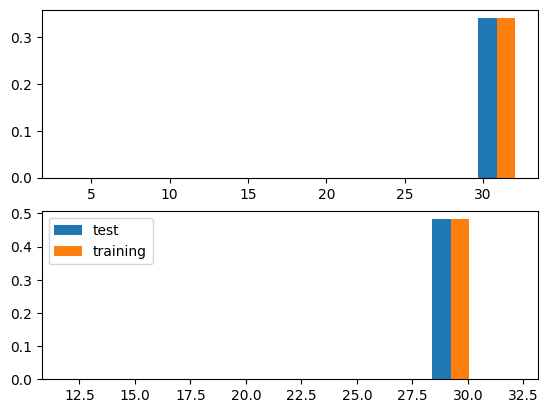

In [51]:
from matplotlib import pyplot as plt

feature = 'altimeter_mean'

fig, axs = plt.subplots(2,1)
axs[0].hist([test_data[feature], train_data[feature]], 
        label=['test', 'training'],
        density=True)
axs[1].hist([test_data[feature], re_train_data[feature]], 
        label=['test', 'training'],
        density=True)
plt.legend()

In [52]:
pd.Series(re_train_data.index).to_csv('adversarial_sampling_0.1.csv')

In [250]:
train_sample_weight.to_csv('sample_weight.csv')

## Sample training data to match test data

In [ ]:
SAMPLE_SIZE = 50000
N_BINS = 300

# Obtain `N_BINS` equal frequency bins, in other words percentiles
step = 100 / N_BINS
test_percentiles = [
    np.percentile(test, q, axis=0)
    for q in np.arange(start=step, stop=100, step=step)
]

# Match each observation in the training set to a bin
train_bins = np.digitize(train, test_percentiles)

# Count the number of values in each training set bin
train_bin_counts = np.bincount(train_bins)

# Weight each observation in the training set based on which bin it is in
weights = 1 / np.array([train_bin_counts[x] for x in train_bins])

# Make the weights sum up to 1
weights_norm = weights / np.sum(weights)

np.random.seed(0)
sample = np.random.choice(train, size=SAMPLE_SIZE, p=weights_norm, replace=False)